In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

- Drop players with more than one team
- Index with tuple for Rk & Player
- Drop the following columns:
     - Unuseful information: Rk, GT, MaxVotes, Tm, Pos
     - Correlation with another feature: FG_tot, 3PA_tot, 2PA_tot, FGA_rank_tot
     - With target information: Votes
- LabelEncode for Player, Pos and Team
- Separate types of columns

In [4]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [5]:
pipe = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [6]:
df = pipe.fit_transform(df)

In [7]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [8]:
len(df[df['Season'] > 2015]) / len(df)

0.17507805847289243

In [9]:
val_df = df[df['Season'] > 2015]
dev_df = df[df['Season'] <= 2015]

In [10]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .35)

In [11]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [12]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [13]:
mlflow.set_experiment('NBA MVP prediction linear model')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/1', experiment_id='1', lifecycle_stage='active', name='NBA MVP prediction linear model', tags={}>

In [14]:
# param_grid = {
#     'max_depth': [6, 8, 10], 
#     'colsample_bytree': [.5], 
#     'learning_rate': [.1],
#     'subsample': [1, .8, .6],
#     'n_estimators': [1000]
#     }

In [15]:
with mlflow.start_run():
    model = LinearRegression(normalize = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10, )

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    # mod.log_params_mlflow_xgb(best_params, sampling_ratio)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model

In [16]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.070567,0.073260,0.064310
R2,0.704631,0.256289,-0.291565


In [17]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [18]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.584536
263,2016,Kawhi Leonard,0.484,0.336908
222,2016,LeBron James,0.482,0.428225
452,2016,Russell Westbrook,0.371,0.456326
126,2016,Kevin Durant,0.112,0.492334
348,2016,Chris Paul,0.082,0.264269
167,2016,Draymond Green,0.038,0.245310
266,2016,Damian Lillard,0.020,0.077707
178,2016,James Harden,0.007,0.343674


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.692222
173,2017,James Harden,0.746,0.590769
261,2017,Kawhi Leonard,0.495,0.384539
221,2017,LeBron James,0.330,0.480094
425,2017,Isaiah Thomas,0.080,0.224256
98,2017,Stephen Curry,0.051,0.278966
16,2017,Giannis Antetokounmpo,0.007,0.250059
453,2017,John Wall,0.007,0.237460
100,2017,Anthony Davis,0.002,0.261314


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.582741
249,2018,LeBron James,0.731,0.559687
122,2018,Anthony Davis,0.441,0.339800
298,2018,Damian Lillard,0.205,0.240046
508,2018,Russell Westbrook,0.075,0.344679
16,2018,Giannis Antetokounmpo,0.074,0.226751
143,2018,Kevin Durant,0.065,0.262645
130,2018,DeMar DeRozan,0.032,0.092114
7,2018,LaMarcus Aldridge,0.006,0.062437


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.507781
207,2019,James Harden,0.768,0.563204
184,2019,Paul George,0.352,0.178678
270,2019,Nikola Jokić,0.210,0.234947
124,2019,Stephen Curry,0.173,0.070630
305,2019,Damian Lillard,0.068,0.212651
155,2019,Joel Embiid,0.049,0.184504
150,2019,Kevin Durant,0.025,0.228129
301,2019,Kawhi Leonard,0.013,0.153930


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.544351
251,2020,LeBron James,0.746,0.398063
199,2020,James Harden,0.363,0.475624
134,2020,Luka Dončić,0.198,0.344063
294,2020,Kawhi Leonard,0.166,0.248188
123,2020,Anthony Davis,0.081,0.308244
396,2020,Chris Paul,0.026,0.141011
297,2020,Damian Lillard,0.023,0.265994
262,2020,Nikola Jokić,0.018,0.208968


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.585053
146,2021,Joel Embiid,0.580,0.218411
116,2021,Stephen Curry,0.449,0.134906
12,2021,Giannis Antetokounmpo,0.345,0.310942
396,2021,Chris Paul,0.138,0.177626
130,2021,Luka Dončić,0.042,0.264391
297,2021,Damian Lillard,0.038,0.163880
421,2021,Julius Randle,0.020,0.160604
439,2021,Derrick Rose,0.010,0.050801


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
2,2016,Jordan Adams,0.0,0.025583
5,2016,Alexis Ajinça,0.0,0.007564
7,2016,LaMarcus Aldridge,0.0,0.073214
8,2016,Cliff Alexander,0.0,0.026694
9,2016,Lavoy Allen,0.0,0.010173
...,...,...,...,...
536,2021,Delon Wright,0.0,0.113064
537,2021,Thaddeus Young,0.0,0.058154
538,2021,Trae Young,0.0,0.165818


In [19]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
97,2016,DeMarcus Cousins,0.0,0.158681
242,2016,DeAndre Jordan,0.0,0.146407
334,2016,J.J. O'Brien,0.0,0.132922
446,2016,John Wall,0.0,0.111838
17,2017,Carmelo Anthony,0.0,0.118896
...,...,...,...,...
524,2021,Kenrich Williams,0.0,0.109325
525,2021,Lou Williams,0.0,0.103020
526,2021,Patrick Williams,0.0,0.123464


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

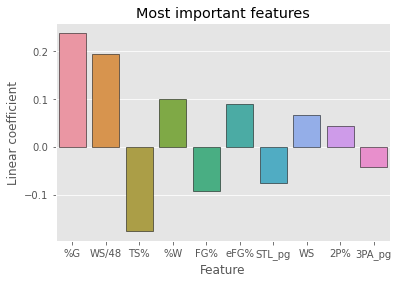

In [20]:
mod.display_linear_coef(model)

In [21]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

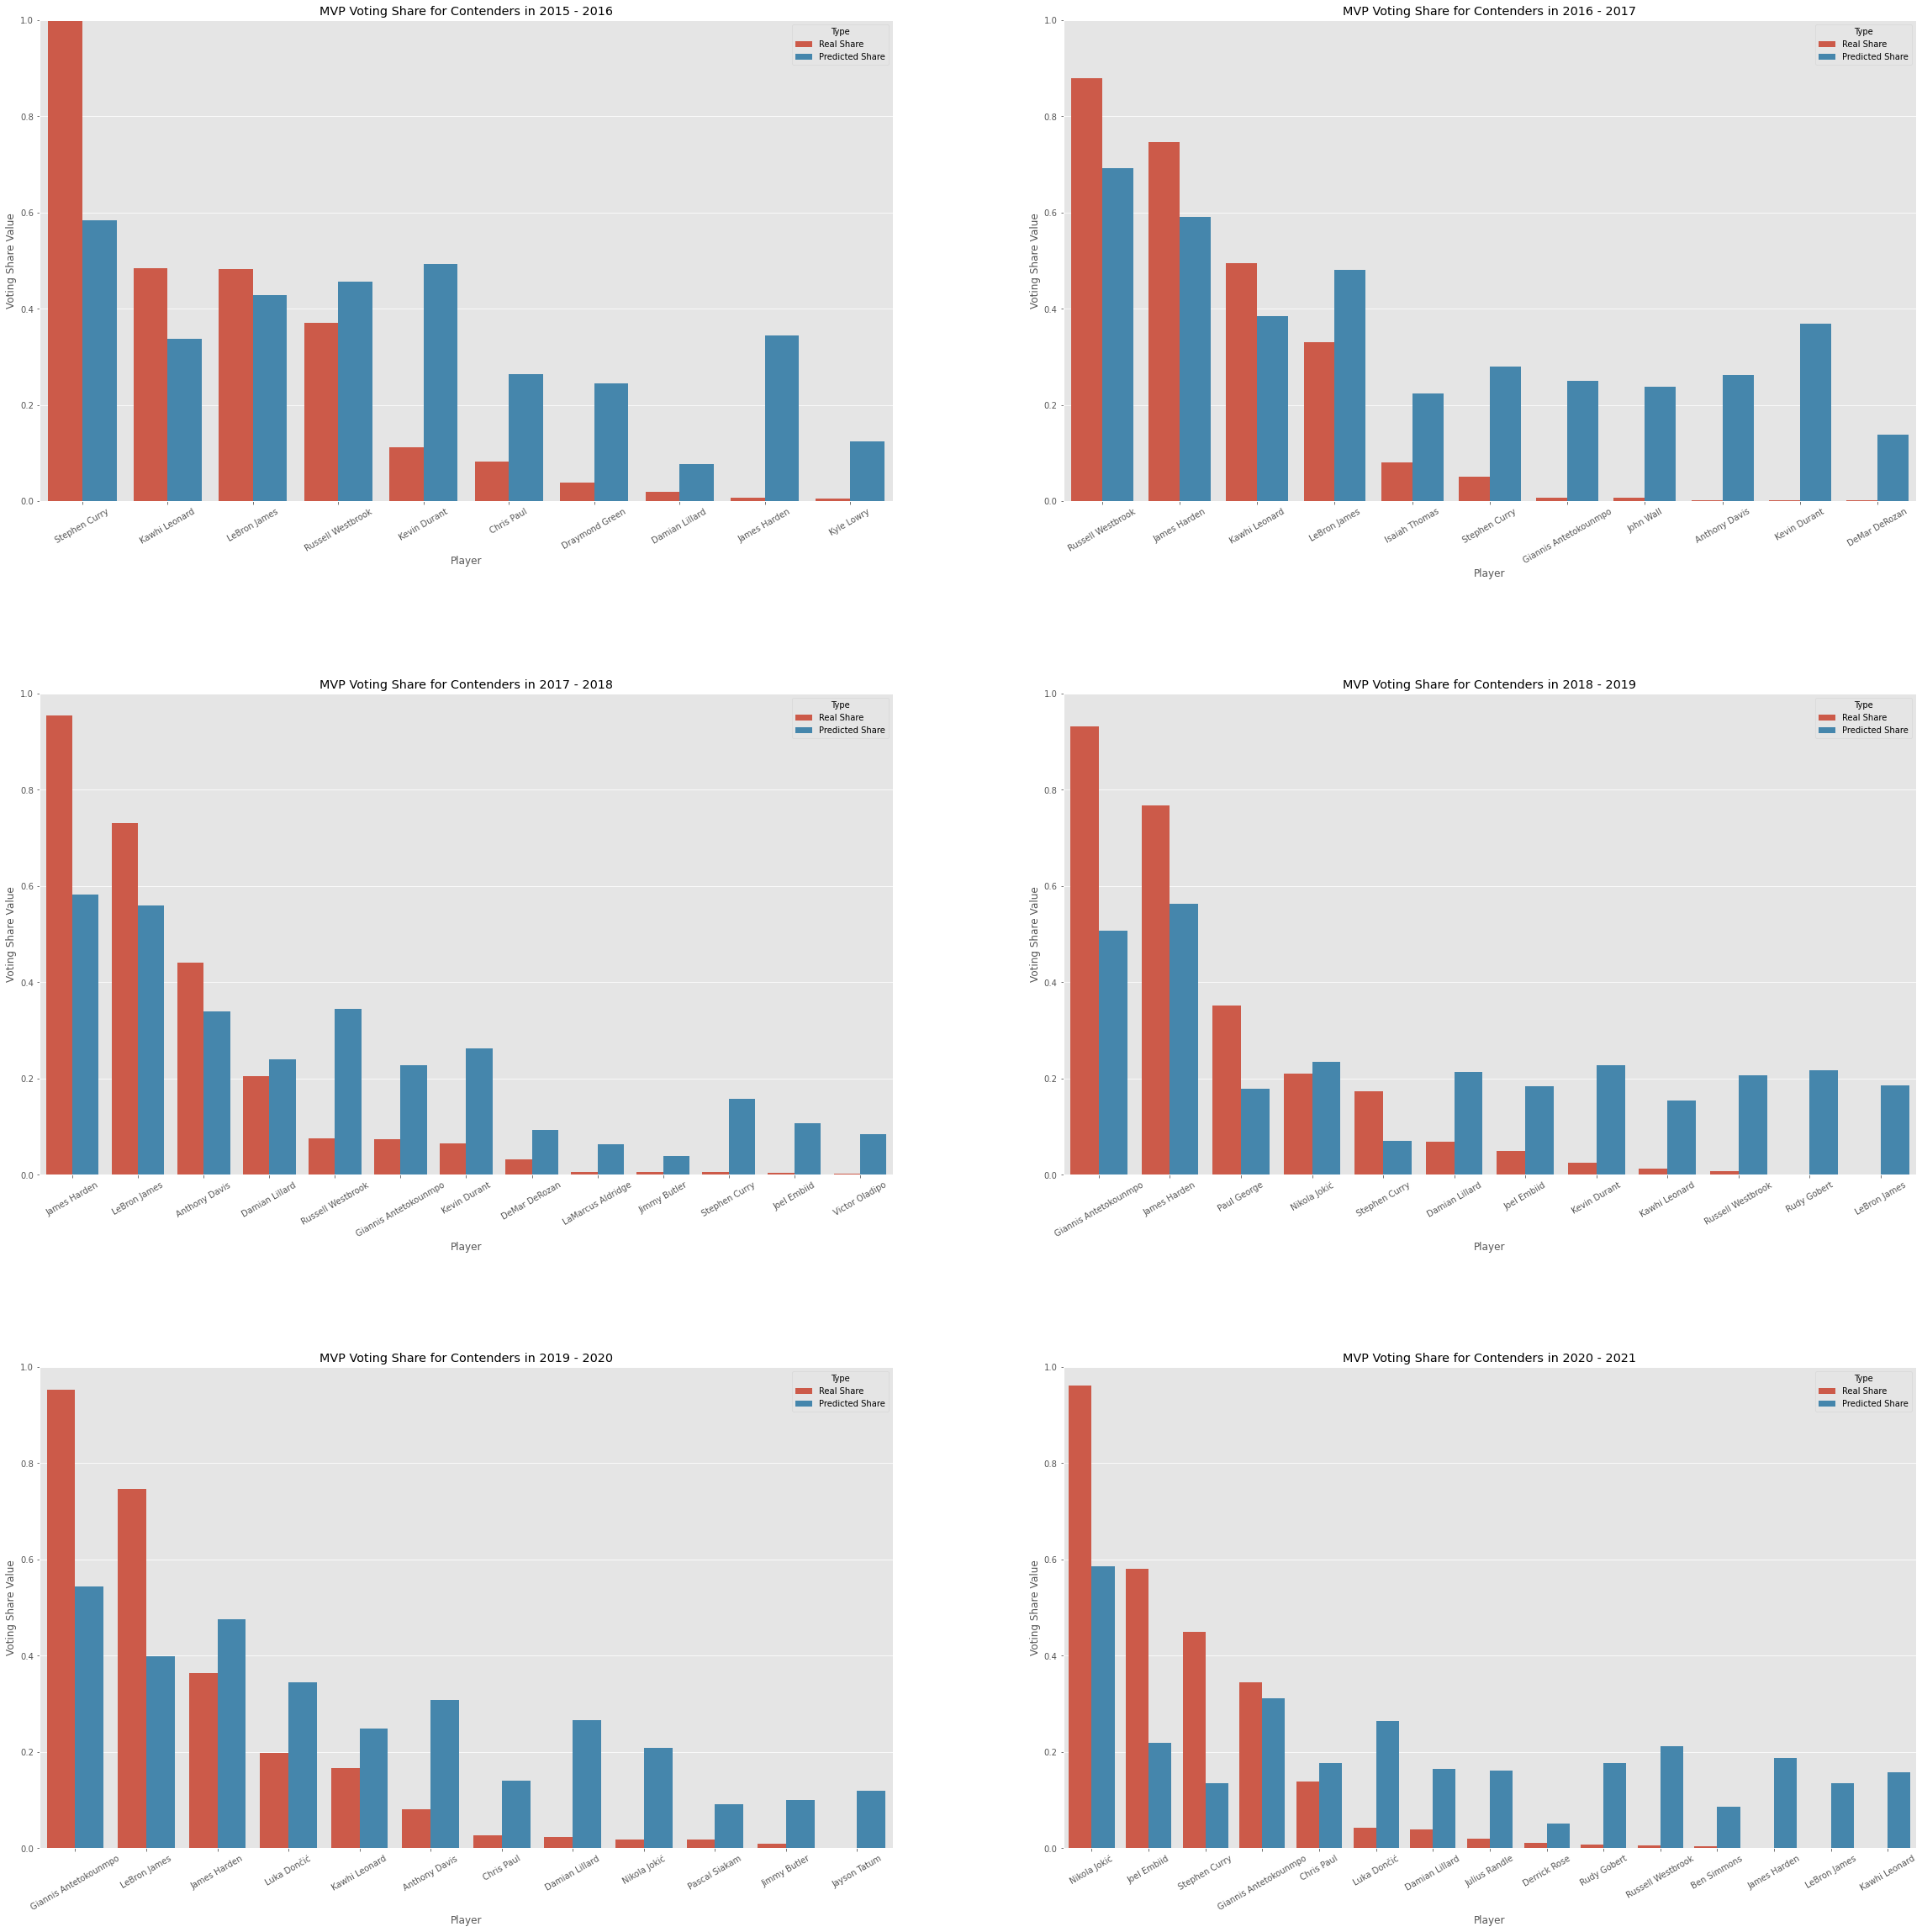

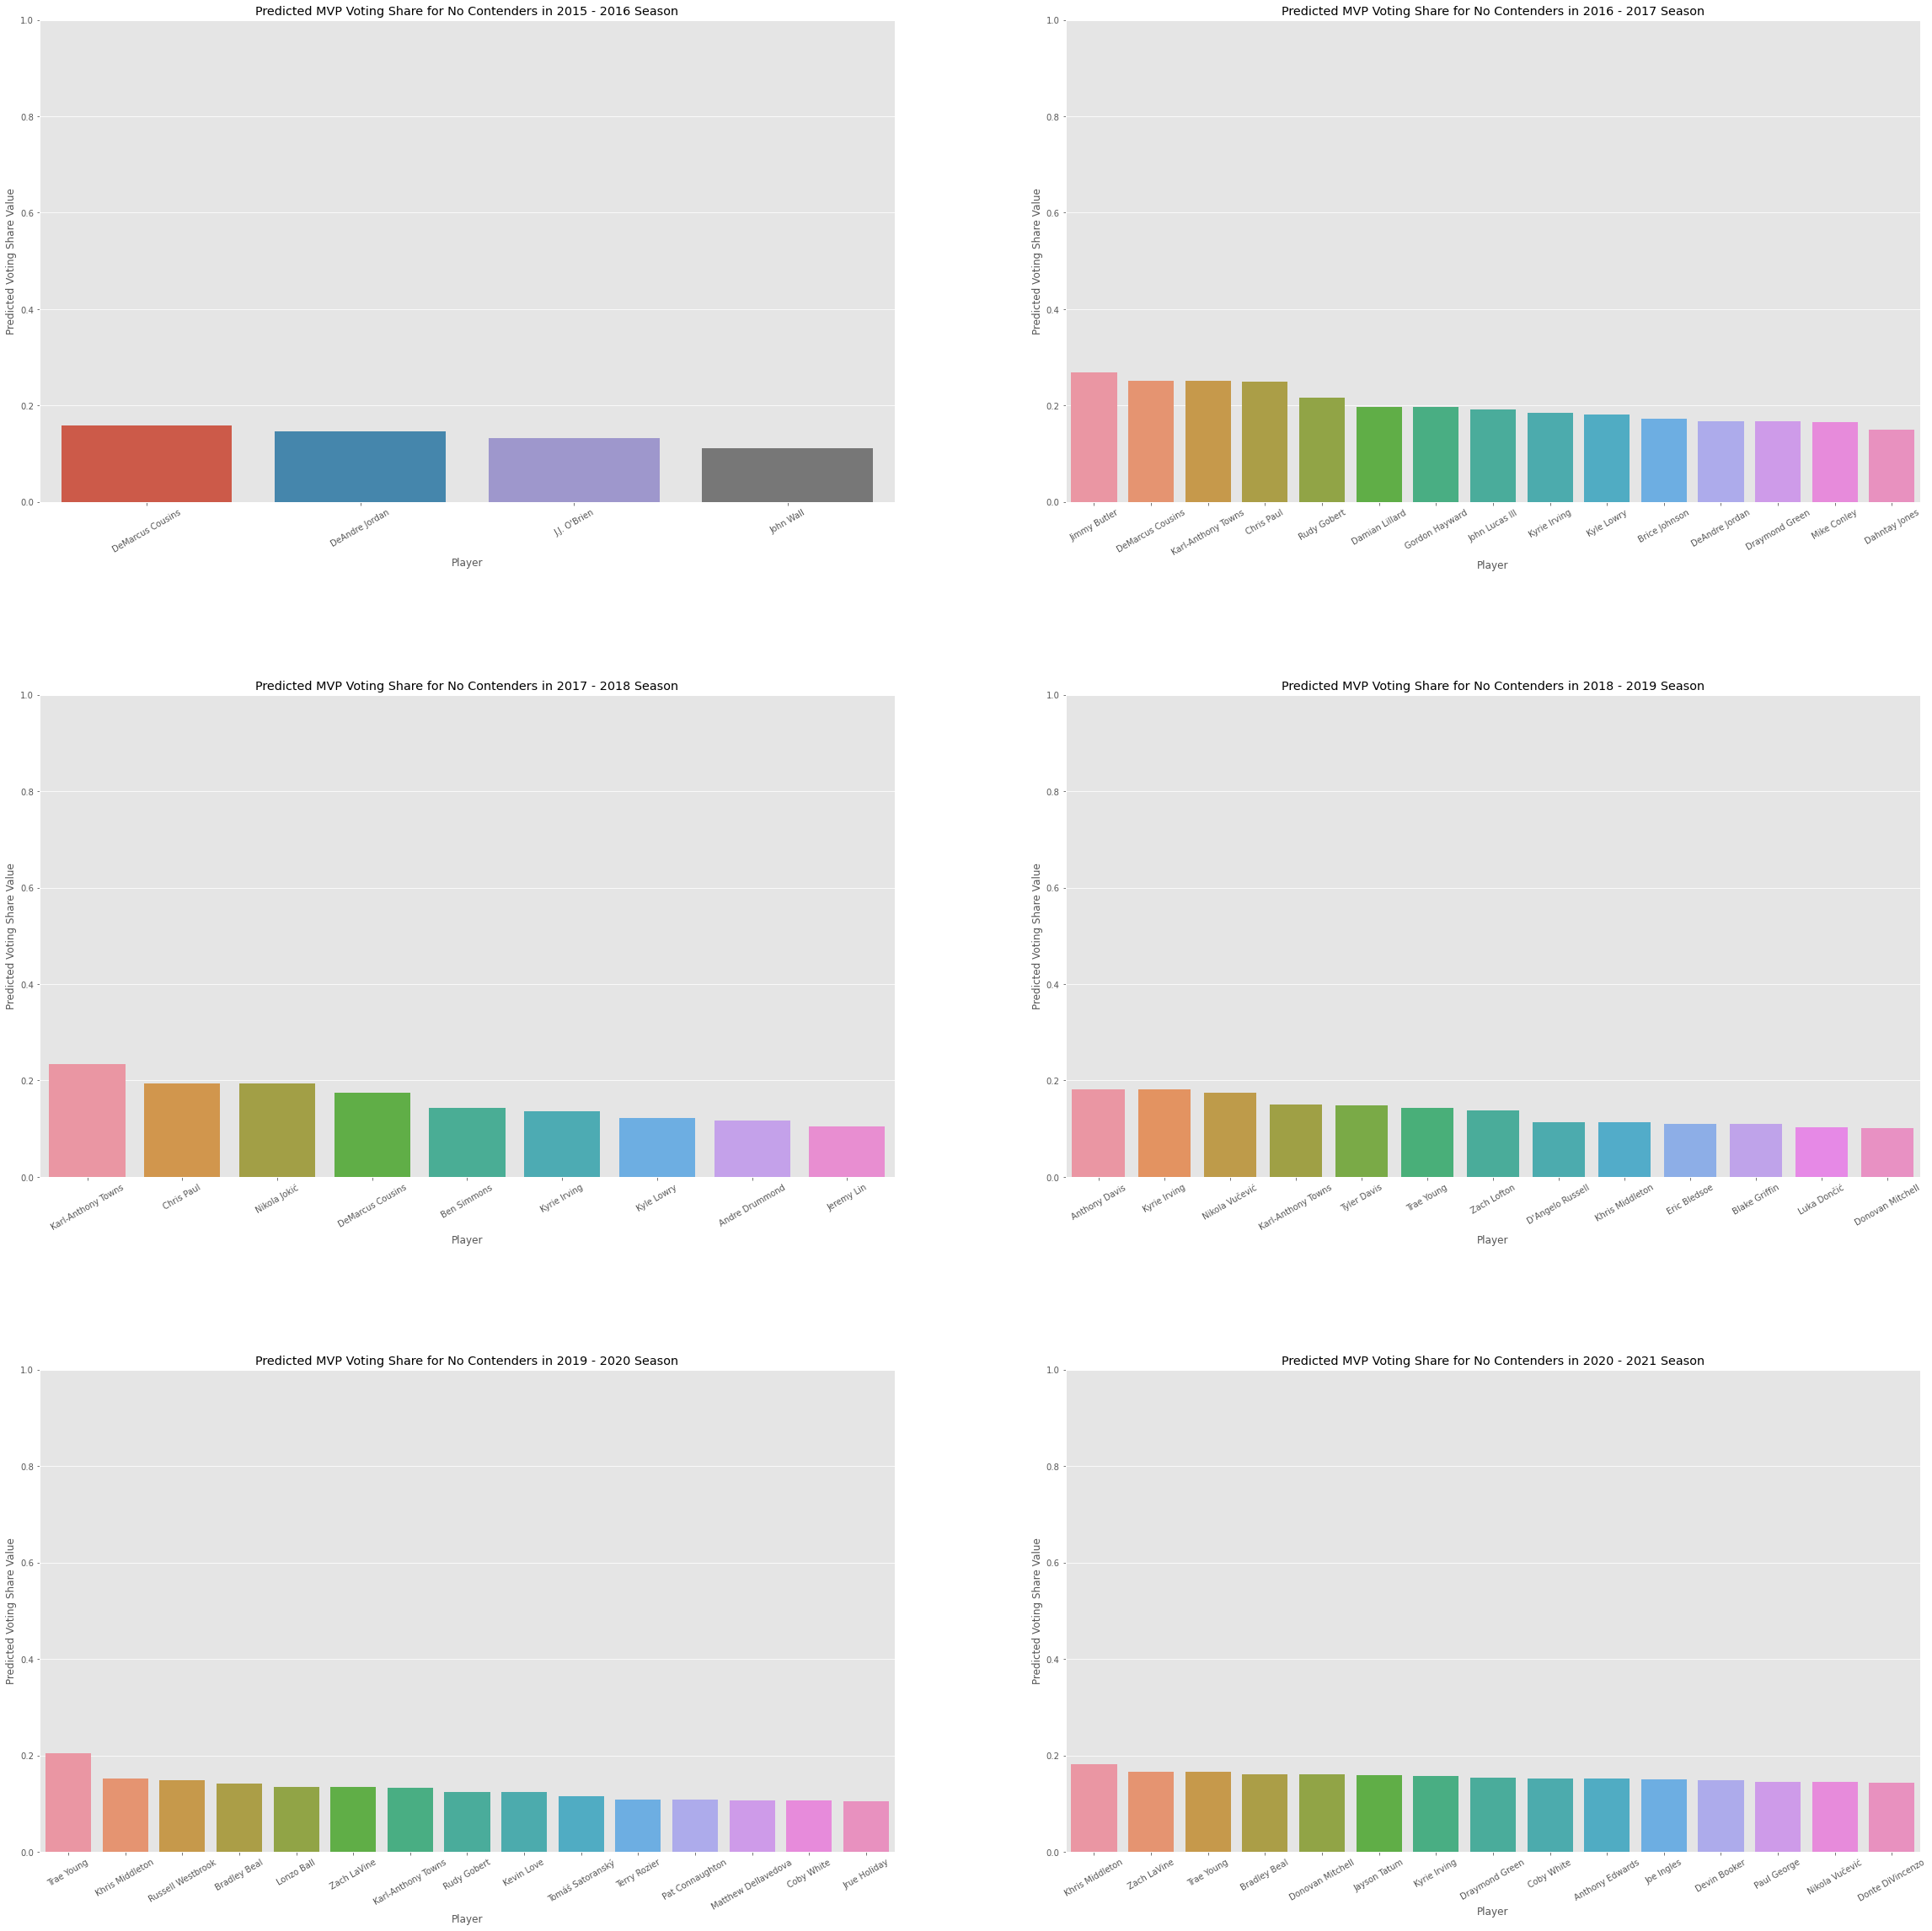

In [22]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [23]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [24]:
# top_features[top_features['Importance'] > 0.005]